# Time Evolution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [2]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [3]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [4]:
from pathlib import Path

# Directory for outputs

path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

# for consistency we will use the template using exp cutoff for both the central source and the DE
# but it will generally require that the cutoff of the DE be frozen and set to infinity (lambda = 0)

model_name = pathmo/"models_template_2cutoff.yaml" 

pathres = Path(path/"time_analysis_alt")
pathres.mkdir(exist_ok=True)

pathres = Path(pathres/"amps_free")
pathres.mkdir(exist_ok=True)

In [5]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## Creating the datasets

In [6]:
datasets_year = Datasets.read(pathma/"datasets_year.yaml")

## Stacking the datasets somehow

In [7]:
# avant après 2014
dataset_pre2014 = Datasets([datasets_year[f'map_{year}'] for year in range(2004,2014)]).stack_reduce()
#dataset_pre2014.name = 'pre2014'
dataset_post2014 = Datasets([datasets_year[f'map_{year}'] for year in range(2014,2020)]).stack_reduce()
#dataset_post2014.name = 'post2014'


# trois périodes pré2012, 2012-2014, post2015
dataset_pre2012 = Datasets([datasets_year[f'map_{year}'] for year in range(2004,2012)]).stack_reduce()
#dataset_pre2012.name = 'pre2012'
dataset_2012_2014 = Datasets([datasets_year[f'map_{year}'] for year in range(2012,2015)]).stack_reduce()
#dataset_2012_2014.name = '2012_2014'
dataset_post2015 = Datasets([datasets_year[f'map_{year}'] for year in range(2015,2020)]).stack_reduce()
#dataset_post2015.name = 'post2015'

## Reading the model template

In [8]:
modelGC,modelG09, modeldiff= Models.read(model_name)

In [9]:
# if needed
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["amplitude"].value = 3.0e-12

modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.77

modelGC.spectral_model.parameters['lambda_'].frozen = True
modelGC.spectral_model.parameters['lambda_'].value = 1/5.4

modeldiff.parameters["amplitude"].frozen = False
modeldiff.parameters["amplitude"].value = 3.0e-12

modeldiff.parameters["index"].frozen = True
modeldiff.parameters["index"].value = 2.24

modeldiff.spectral_model.parameters['lambda_'].frozen = True
modeldiff.spectral_model.parameters['lambda_'].value = 0.0

## Constructing the mask

In [10]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [11]:
dataset_pre2014.fit_mask = fit_mask
bkg_model = FoVBackgroundModel(dataset_name = dataset_pre2014.name)
dataset_pre2014.models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]

dataset_post2014.fit_mask = fit_mask
bkg_model = FoVBackgroundModel(dataset_name = dataset_post2014.name)
dataset_post2014.models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]


dataset_pre2012.fit_mask = fit_mask
bkg_model = FoVBackgroundModel(dataset_name = dataset_pre2012.name)
dataset_pre2012.models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]

dataset_2012_2014.fit_mask = fit_mask
bkg_model = FoVBackgroundModel(dataset_name = dataset_2012_2014.name)
dataset_2012_2014.models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]

dataset_post2015.fit_mask = fit_mask
bkg_model = FoVBackgroundModel(dataset_name = dataset_post2015.name)
dataset_post2015.models =  [modelGC.copy(),modelG09.copy(),modeldiff.copy(),bkg_model]

# Fitting the datasets

In [160]:
%%time

fit = Fit([dataset_pre2014])
result = fit.run()

fit = Fit([dataset_post2014])
result = fit.run()

fit = Fit([dataset_pre2012])
result = fit.run()

fit = Fit([dataset_2012_2014])
result = fit.run()

fit = Fit([dataset_post2015])
result = fit.run()

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


CPU times: user 1min 37s, sys: 8.21 s, total: 1min 46s
Wall time: 1min 46s


# Saving the results

### shape of the spectral models

In [161]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(12,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"HESS J175-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"HESS J175-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse              : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse              : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

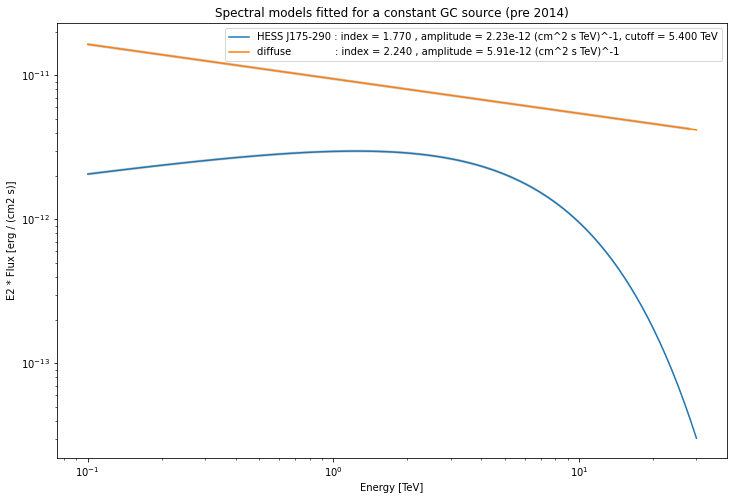

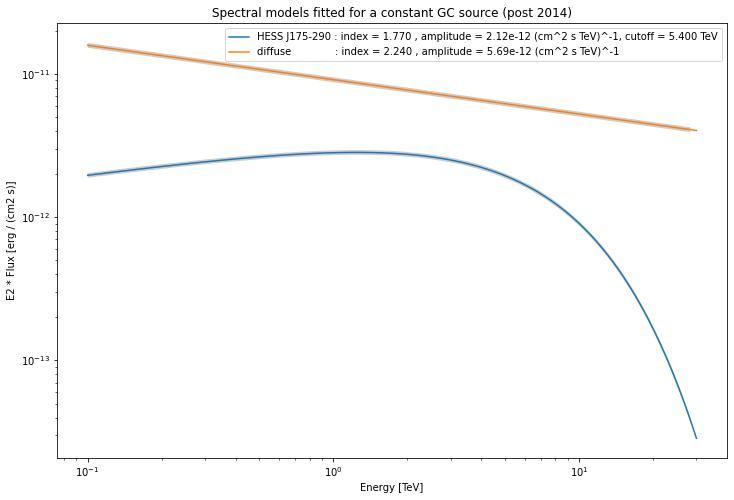

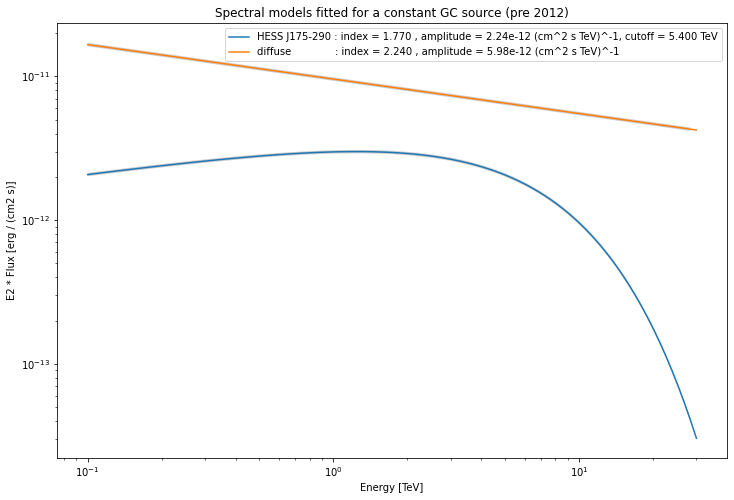

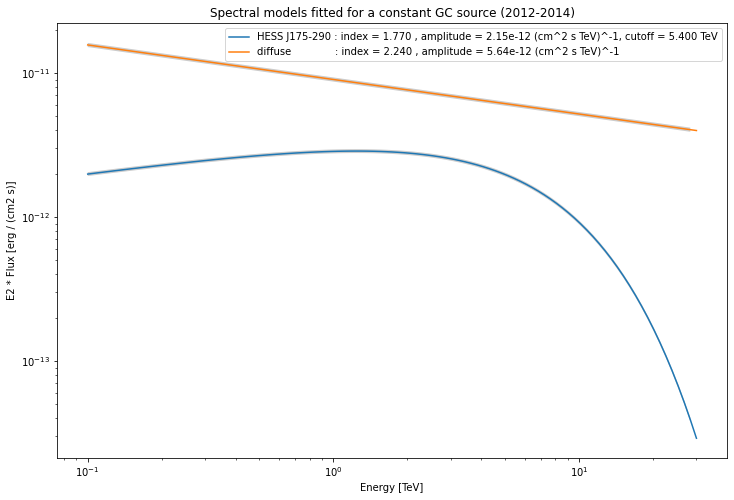

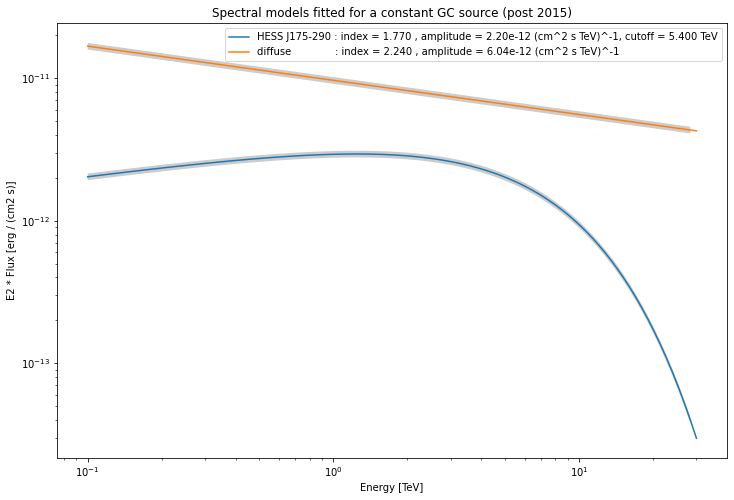

In [162]:
plot_spectrum(dataset_pre2014.models, pathres,"pre2014_spectrum.pdf", "pre 2014")
plot_spectrum(dataset_post2014.models, pathres,"post2014_spectrum.pdf", "post 2014")

plot_spectrum(dataset_pre2012.models, pathres,"pre2012_spectrum.pdf", "pre 2012")
plot_spectrum(dataset_2012_2014.models, pathres,"2012-2014_spectrum.pdf", "2012-2014")
plot_spectrum(dataset_post2015.models, pathres,"post2015_spectrum.pdf", "post 2015")

## Time evolution of the fluxes

In [163]:
def CalculateFluxFromModels(mapdataset, emin, emax):
    models  = mapdataset.models
    
    ampGC = models[0].spectral_model.parameters['amplitude'].value
    amp_errGC = models[0].spectral_model.parameters['amplitude'].error
    
    ampdiff = models[2].spectral_model.parameters['amplitude'].value
    amp_errdiff = models[2].spectral_model.parameters['amplitude'].error
    
    #norm = mapdataset.background_model.parameters['norm'].value
    #norm_err = mapdataset.background_model.parameters['norm'].error
    
    if isinstance(emin, u.Quantity):

        diff_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diff_flux = models[2].spectral_model.integral(emin, emax)
        GC_flux = models[0].spectral_model.integral(emin, emax)
        
    fluxerrGC = (GC_flux/ampGC)*amp_errGC
    fluxerrdiff = (diff_flux/ampdiff)*amp_errdiff

    cross_term = 2*(mapdataset.models.covariance.data[1,13]*fluxerrGC*fluxerrdiff)/(GC_flux*diff_flux)
      
    flux_rap_err = (GC_flux/diff_flux)*np.sqrt((fluxerrGC/GC_flux)**2 + (fluxerrdiff/diff_flux)**2 - cross_term )

    return GC_flux, diff_flux, GC_flux/diff_flux, fluxerrGC, fluxerrdiff, flux_rap_err

In [164]:
emin = 1.0*u.TeV
emax = 10*u.TeV

a, b, flux_ratio, c, d, flux_rap_err = CalculateFluxFromModels(dataset_pre2014, emin, emax)
ratio_pre2014 = [flux_ratio,flux_rap_err]
a, b, flux_ratio, c, d, flux_rap_err = CalculateFluxFromModels(dataset_post2014, emin, emax)
ratio_post2014 = [flux_ratio,flux_rap_err]


a, b, flux_ratio, c, d, flux_rap_err = CalculateFluxFromModels(dataset_pre2012, emin, emax)
ratio_pre2012 = [flux_ratio,flux_rap_err]
a, b, flux_ratio, c, d, flux_rap_err = CalculateFluxFromModels(dataset_2012_2014, emin, emax)
ratio_2012_2014 = [flux_ratio,flux_rap_err]
a, b, flux_ratio, c, d, flux_rap_err = CalculateFluxFromModels(dataset_post2015, emin, emax)
ratio_post2015 = [flux_ratio,flux_rap_err]

présenter tout ça correctement et graphiquement

In [165]:
x1 =[2009, 2017]
x1err = [5, 3]
y1 = [ratio_pre2014[0],ratio_post2014[0]]
y1err = [ratio_pre2014[1],ratio_post2014[1]]

x2 =[2008.5, 2014, 2017.5]
x2err = [4.5,1, 2.5]
y2 = [ratio_pre2012[0],ratio_2012_2014[0], ratio_post2015[0]]
y2err = [ratio_pre2012[1],ratio_2012_2014[1],ratio_post2015[1]]

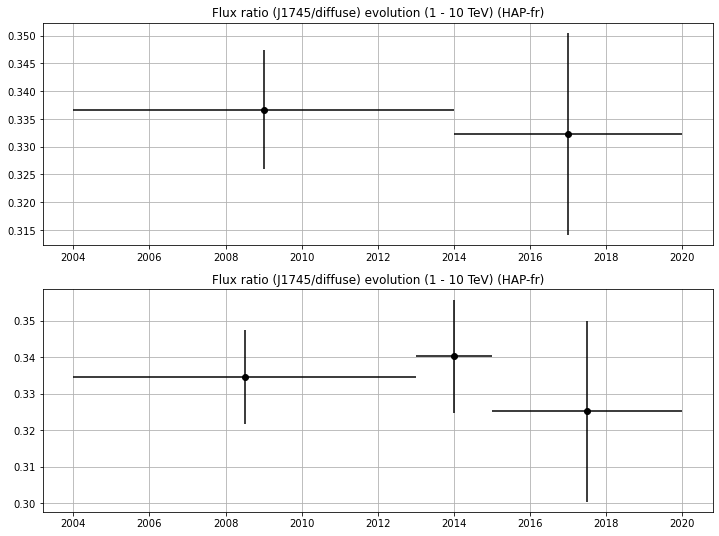

In [166]:
plt.figure(figsize=(12,9))

ax1 = plt.subplot(2,1,1)

plt.errorbar(x1, y1, xerr=x1err, yerr=y1err, fmt='ko')
plt.title("Flux ratio (J1745/diffuse) evolution (1 - 10 TeV) (HAP-fr)")
plt.grid()

ax2 = plt.subplot(2,1,2)
plt.errorbar(x2, y2, xerr=x2err, yerr=y2err, fmt='ko')
plt.title("Flux ratio (J1745/diffuse) evolution (1 - 10 TeV) (HAP-fr)")
plt.grid()

plt.savefig(pathres/"flux_ratio_evolution_all_params_free.pdf")

## Fitting a time evolution model

In [167]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

### Evolution of the ratio

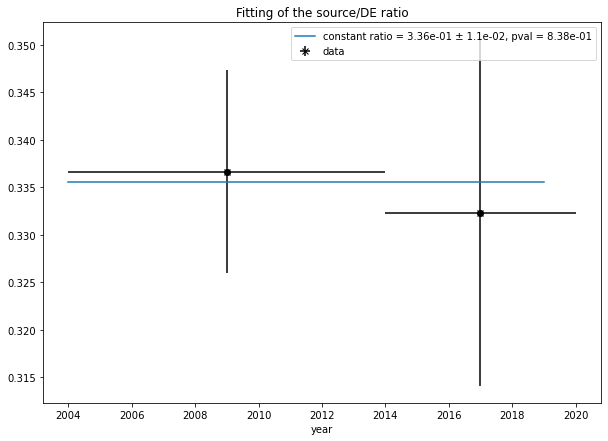

In [168]:
years = [ k for k in range(2004,2020)]
x =  np.array(x1)
y =  np.array(y1)
y_uncs = np.array(y1err)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = y1err

pv = pval(A1, A2, err_bars, len(A1)-1)

error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y,xerr=x1err, yerr=y_uncs, fmt='kx', label="data")
plt.plot(years, t(years), label=f"constant ratio = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.2e}")
plt.xlabel('year')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Fitting of the source/DE ratio")
plt.savefig(pathres/"LC_ratio_2periods.pdf")

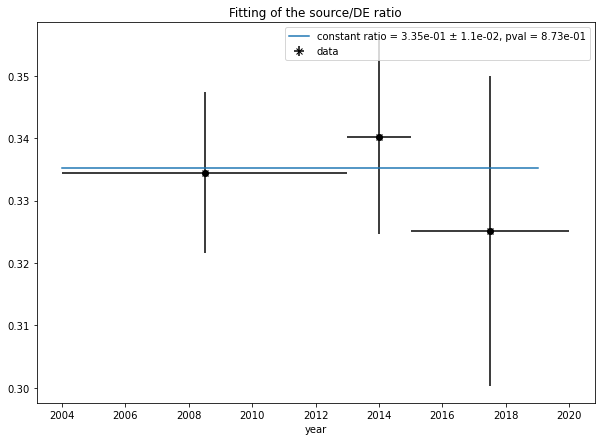

In [169]:
years = [ k for k in range(2004,2020)]
x =  np.array(x2)
y =  np.array(y2)
y_uncs = np.array(y2err)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = y2err

pv = pval(A1, A2, err_bars, len(A1)-1)

error_const = np.sqrt(sum([a**2 for a in err_bars]))/len(A1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y,xerr=x2err, yerr=y_uncs, fmt='kx', label="data")
plt.plot(years, t(years), label=f"constant ratio = {A2:0.2e} ± {error_const:0.1e}, pval = {pv:0.2e}")
plt.xlabel('year')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Fitting of the source/DE ratio")
plt.savefig(pathres/"LC_ratio_3periods.pdf")

## Model predictions

In [170]:
pathm = Path(pathres/"model_maps")
pathm.mkdir(exist_ok=True)

def model_prediction(dataset, namefile, namefig):
    plt.figure(figsize=(5,5))
    dataset.npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
    plt.title("model prediction (npred) " + namefig)
    
    name ="model_"+ namefile+"_map_fr.pdf"
    plt.savefig(pathm/name)

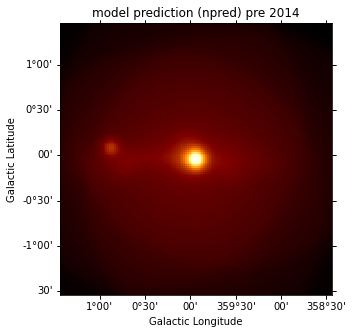

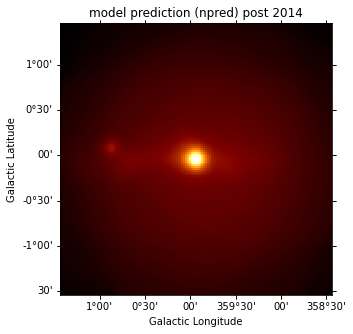

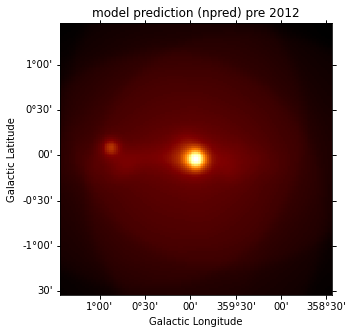

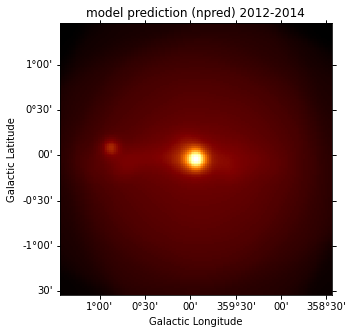

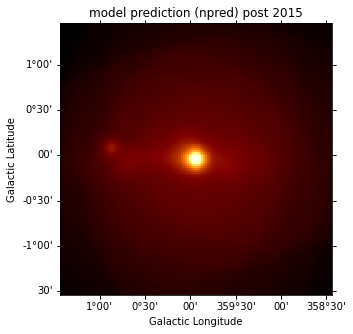

In [171]:
model_prediction(dataset_pre2014,"pre2014", "pre 2014")
model_prediction(dataset_post2014, "post2014", "post 2014")

model_prediction(dataset_pre2012, "pre2012", "pre 2012")
model_prediction(dataset_2012_2014, "2012-2014", "2012-2014")
model_prediction(dataset_post2015,"post2015", "post 2015")

## Residuals

In [172]:
pathr = Path(pathres/"residuals")
pathr.mkdir(exist_ok=True)

kwargs_spatial = {'vmin':-1, 'vmax':1 } # nécessaire ?

kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)}

def residuals(dataset, namefile, namefig):
    dataset.plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    plt.title("residuals (diff/sqrt(model)) " + namefig)
    name = "residuals_" + namefile +"_fr.pdf"
    plt.savefig(pathr/name, overwrite=True)

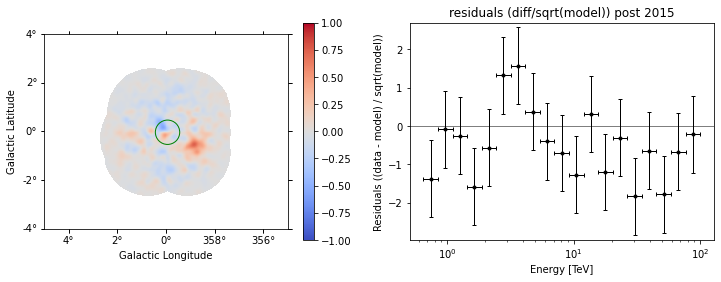

In [173]:
residuals(dataset_pre2014,"pre2014", "pre 2014")
residuals(dataset_post2014, "post2014", "post 2014")

residuals(dataset_pre2012, "pre2012", "pre 2012")
residuals(dataset_2012_2014, "2012-2014", "2012-2014")
residuals(dataset_post2015,"post2015", "post 2015")

## Significance

In [174]:
from scipy.stats import norm

paths = Path(pathres/"significance")
paths.mkdir(exist_ok=True)
pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)


def significance(dataset, namefile, namefig):
    plt.figure()

    lima_estimator = ExcessMapEstimator("0.2 deg", selection_optional=[] )
    
    res =  lima_estimator.run(dataset)
    
    res['sqrt_ts'].plot(add_cbar=True)
    
    name = "significance_"+namefile+"_fr.pdf"
    
    plt.title("Significance map (data v. predictions) "+namefig)
    plt.savefig(paths/name, overwrite=True)
    
    
    plt.figure()
    signidata = res['sqrt_ts'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    plt.hist(signidata[0,mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[0,mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist"+namefile+"_fr.pdf"
    plt.title("Significance distribution on the central (3°,1.5°) "+namefig)
    plt.savefig(pathh/name, overwrite=True)

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/a

CPU times: user 39.3 s, sys: 6.97 s, total: 46.3 s
Wall time: 43.9 s


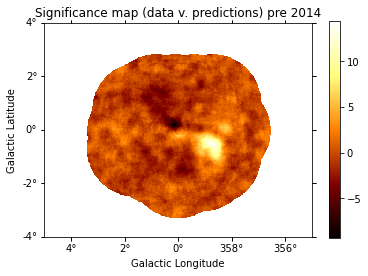

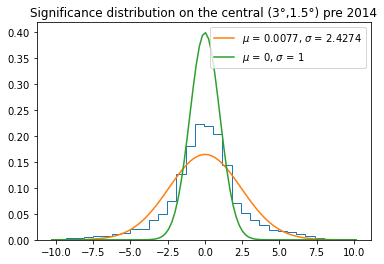

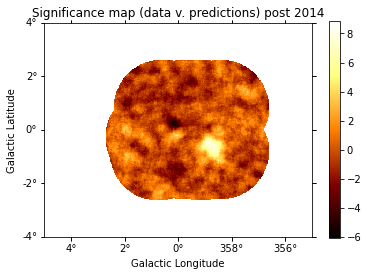

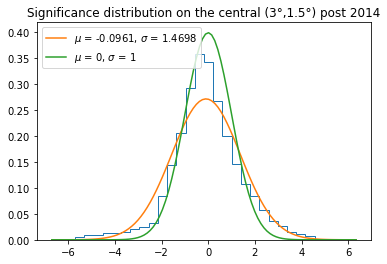

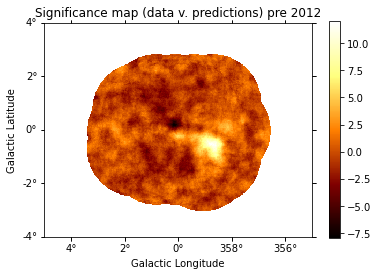

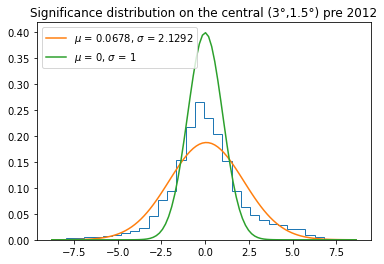

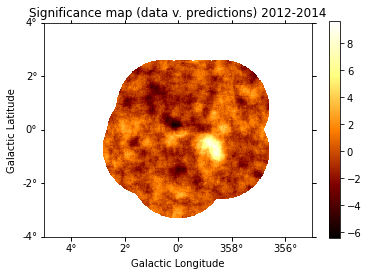

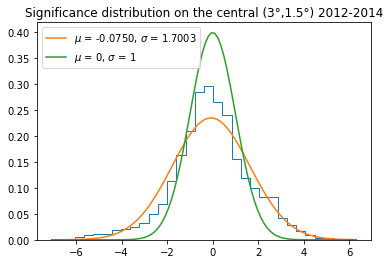

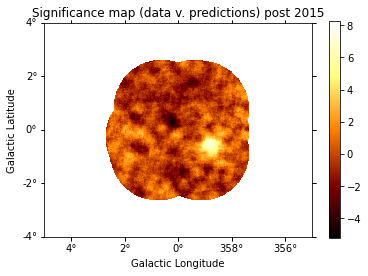

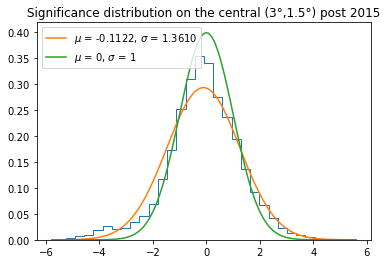

In [175]:
%%time

significance(dataset_pre2014,"pre2014", "pre 2014")
significance(dataset_post2014, "post2014", "post 2014")

significance(dataset_pre2012, "pre2012", "pre 2012")
significance(dataset_2012_2014, "2012-2014", "2012-2014")
significance(dataset_post2015,"post2015", "post 2015")

## Flux points

In [12]:
pathFP = Path(pathres/"fluxpoints")
pathFP.mkdir(exist_ok=True)

def FluxPointsFitting(dataset, e_edges, namefile):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =0) 
    flux_points = fpe.run(datasets=[dataset])
    flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[0])
    plt.figure(figsize=(8, 6))
    flux_points_dataset.plot_fit()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)

In [13]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found
HDU 'MASK_FIT' not found


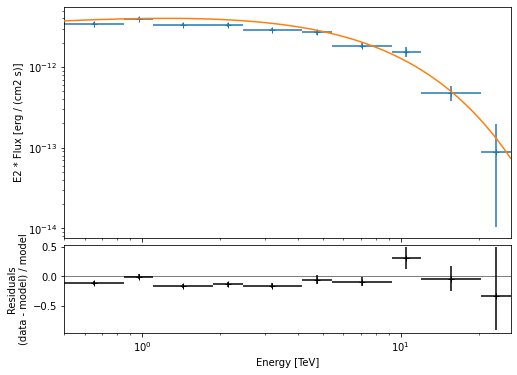

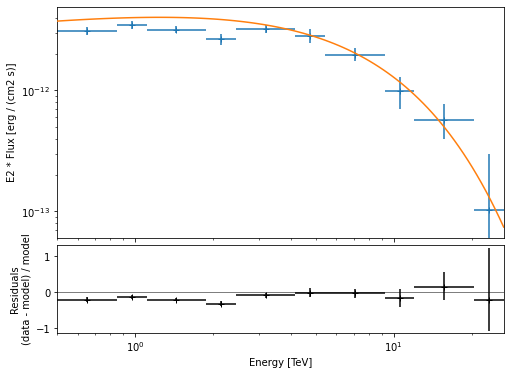

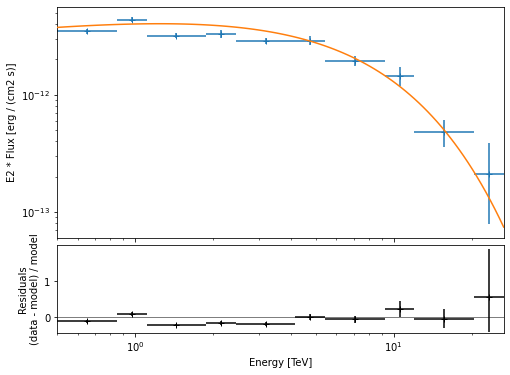

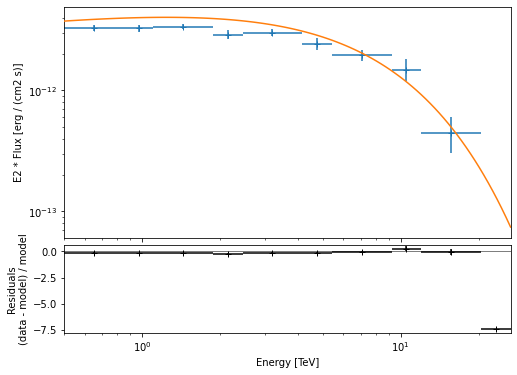

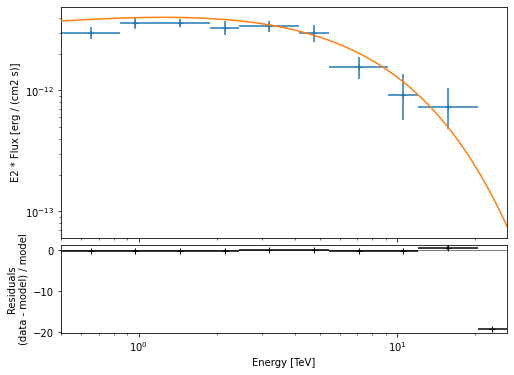

In [14]:
FluxPointsFitting(dataset_pre2014, e_edges, "pre2014")
FluxPointsFitting(dataset_post2014, e_edges, "post2014")

FluxPointsFitting(dataset_pre2012, e_edges, "pre2012")
FluxPointsFitting(dataset_2012_2014, e_edges, "2012_2014")
FluxPointsFitting(dataset_post2015, e_edges, "post2015")